In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
from anndata import AnnData
import scanpy as sc
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

from cov import util, viz

sns.set(style="ticks", palette="tab10")

# load data and make adata object

This notebook looks at the expression of ACE2 in a dataset from the mouse olfactory epithelium.

To run this notebook, first download the `GSE151346_MOE_metadata.tsv.gz` and `GSE151346_MOE_all_counts.csv.gz` files from the NCBI GEO at [GSE151346](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE151346) and save them to `data/raw/GSE151346_MOE`.

In [3]:
data_folds = util.get_data_folders()
wom_fold = util.get_raw_folders("mouse_OE")

In [4]:
df_meta = pd.read_csv(wom_fold / "GSE151346_MOE_metadata.tsv.gz", index_col=0, sep="\t")
df_meta.head()

,n_genes,n_counts,orig_ident,percent_mito,doublet_score,leiden,leiden_name,UMAP_1,UMAP_2
index,,,,,,,,,
0105_AGGATAGCCTAT,2575,7447.0,0105,0.046059,0.060801,21,Bowman's gland,-5.752651,4.144787
0105_GTATATGTCCGT,2095,6312.0,0105,0.031691,0.103269,21,Bowman's gland,-5.474570,5.911453
0105_ACAACGCGGACC,2384,5818.0,0105,0.025438,0.127758,21,Bowman's gland,-5.530327,4.693328
0105_ATCACGACAGAA,2410,5771.0,0105,0.044375,0.122662,21,Bowman's gland,-5.589942,3.968730
0105_GAACACTTTGGT,2163,4852.0,0105,0.026587,0.057412,21,Bowman's gland,-5.904112,4.687451


In [5]:
ad_fn = data_folds.processed / "Mouse_WOM.h5ad"
save = True
if ad_fn.exists():
    print("Loading h5ad file")
    adata = sc.read(ad_fn)
else:
    df_counts = pd.read_csv(
        wom_fold / "GSE151346_MOE_all_counts.csv.gz", index_col=0, low_memory=False
    )
    
    assert df_meta.index.isin(df_counts.columns).all()
    adata = AnnData(df_counts[df_meta.index].T)
    adata.X = sparse.csr_matrix(adata.X)
    assert adata.obs_names.equals(df_meta.index)

    adata.obs = df_meta.copy()
    adata.obsm["X_umap"] = df_meta[["UMAP_1", "UMAP_2"]].values

    adata.raw = adata.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    
    if save:
        print(f"Saving h5ad file to {ad_fn}")
        adata.write_h5ad(ad_fn)
print(adata)

Loading h5ad file
AnnData object with n_obs × n_vars = 29585 × 38378
    obs: 'n_genes', 'n_counts', 'orig_ident', 'percent_mito', 'doublet_score', 'leiden', 'leiden_name', 'UMAP_1', 'UMAP_2'
    obsm: 'X_umap'


/Users/davidbrann/miniconda3/envs/covid/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


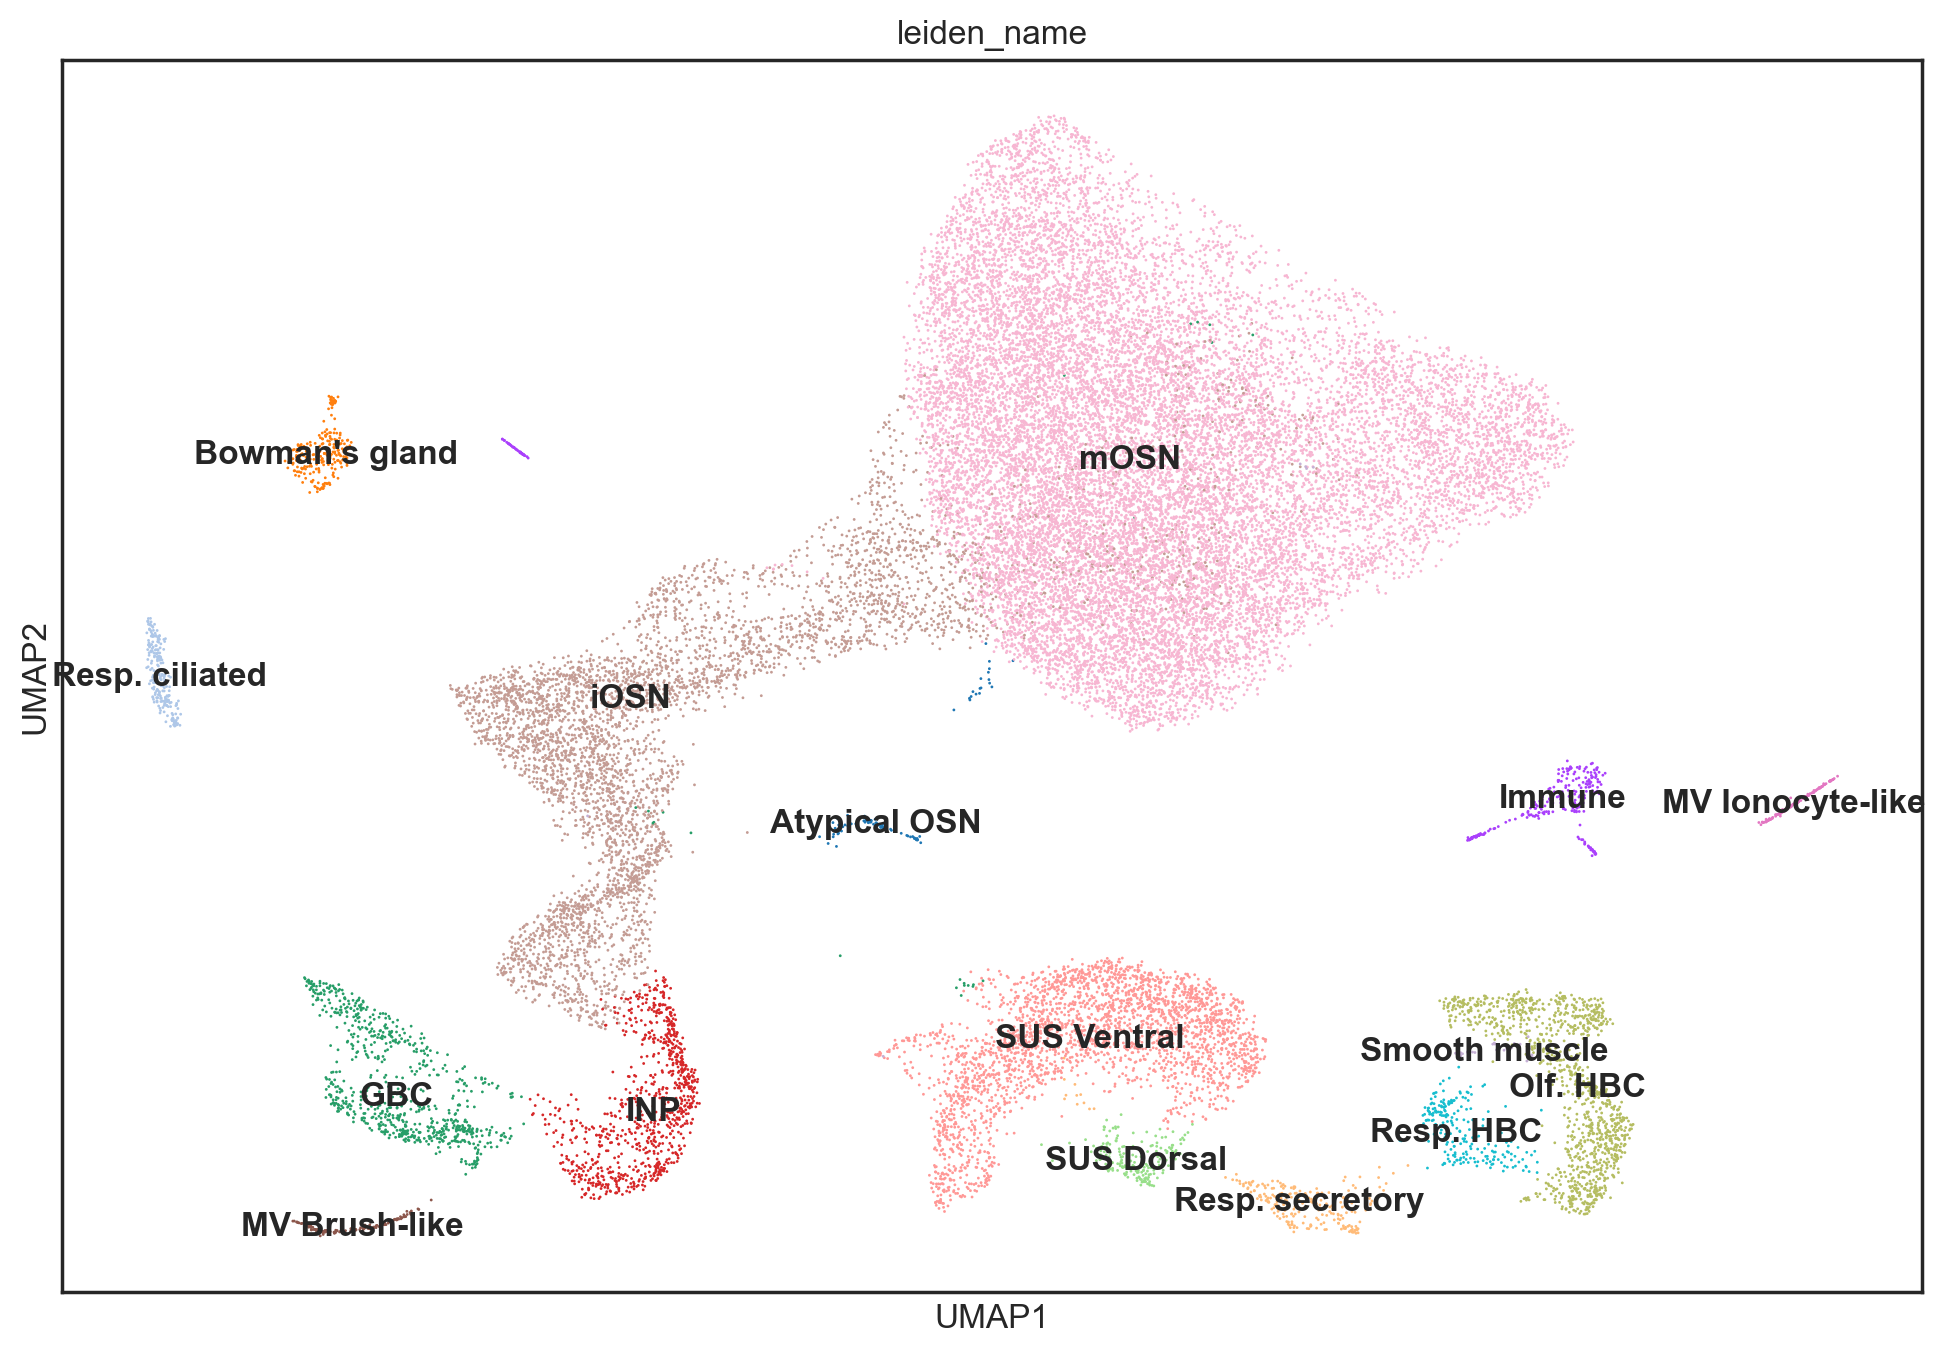

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
sc.pl.umap(adata, color="leiden_name", ax=ax, legend_loc="on data")

# plot ACE2 expression in SUS cells

In [7]:
is_sus = adata.obs.leiden_name.str.contains("SUS")
adata_sus = adata[is_sus].copy()
print(adata_sus)

AnnData object with n_obs × n_vars = 2889 × 38378
    obs: 'n_genes', 'n_counts', 'orig_ident', 'percent_mito', 'doublet_score', 'leiden', 'leiden_name', 'UMAP_1', 'UMAP_2'
    uns: 'leiden_name_colors'
    obsm: 'X_umap'


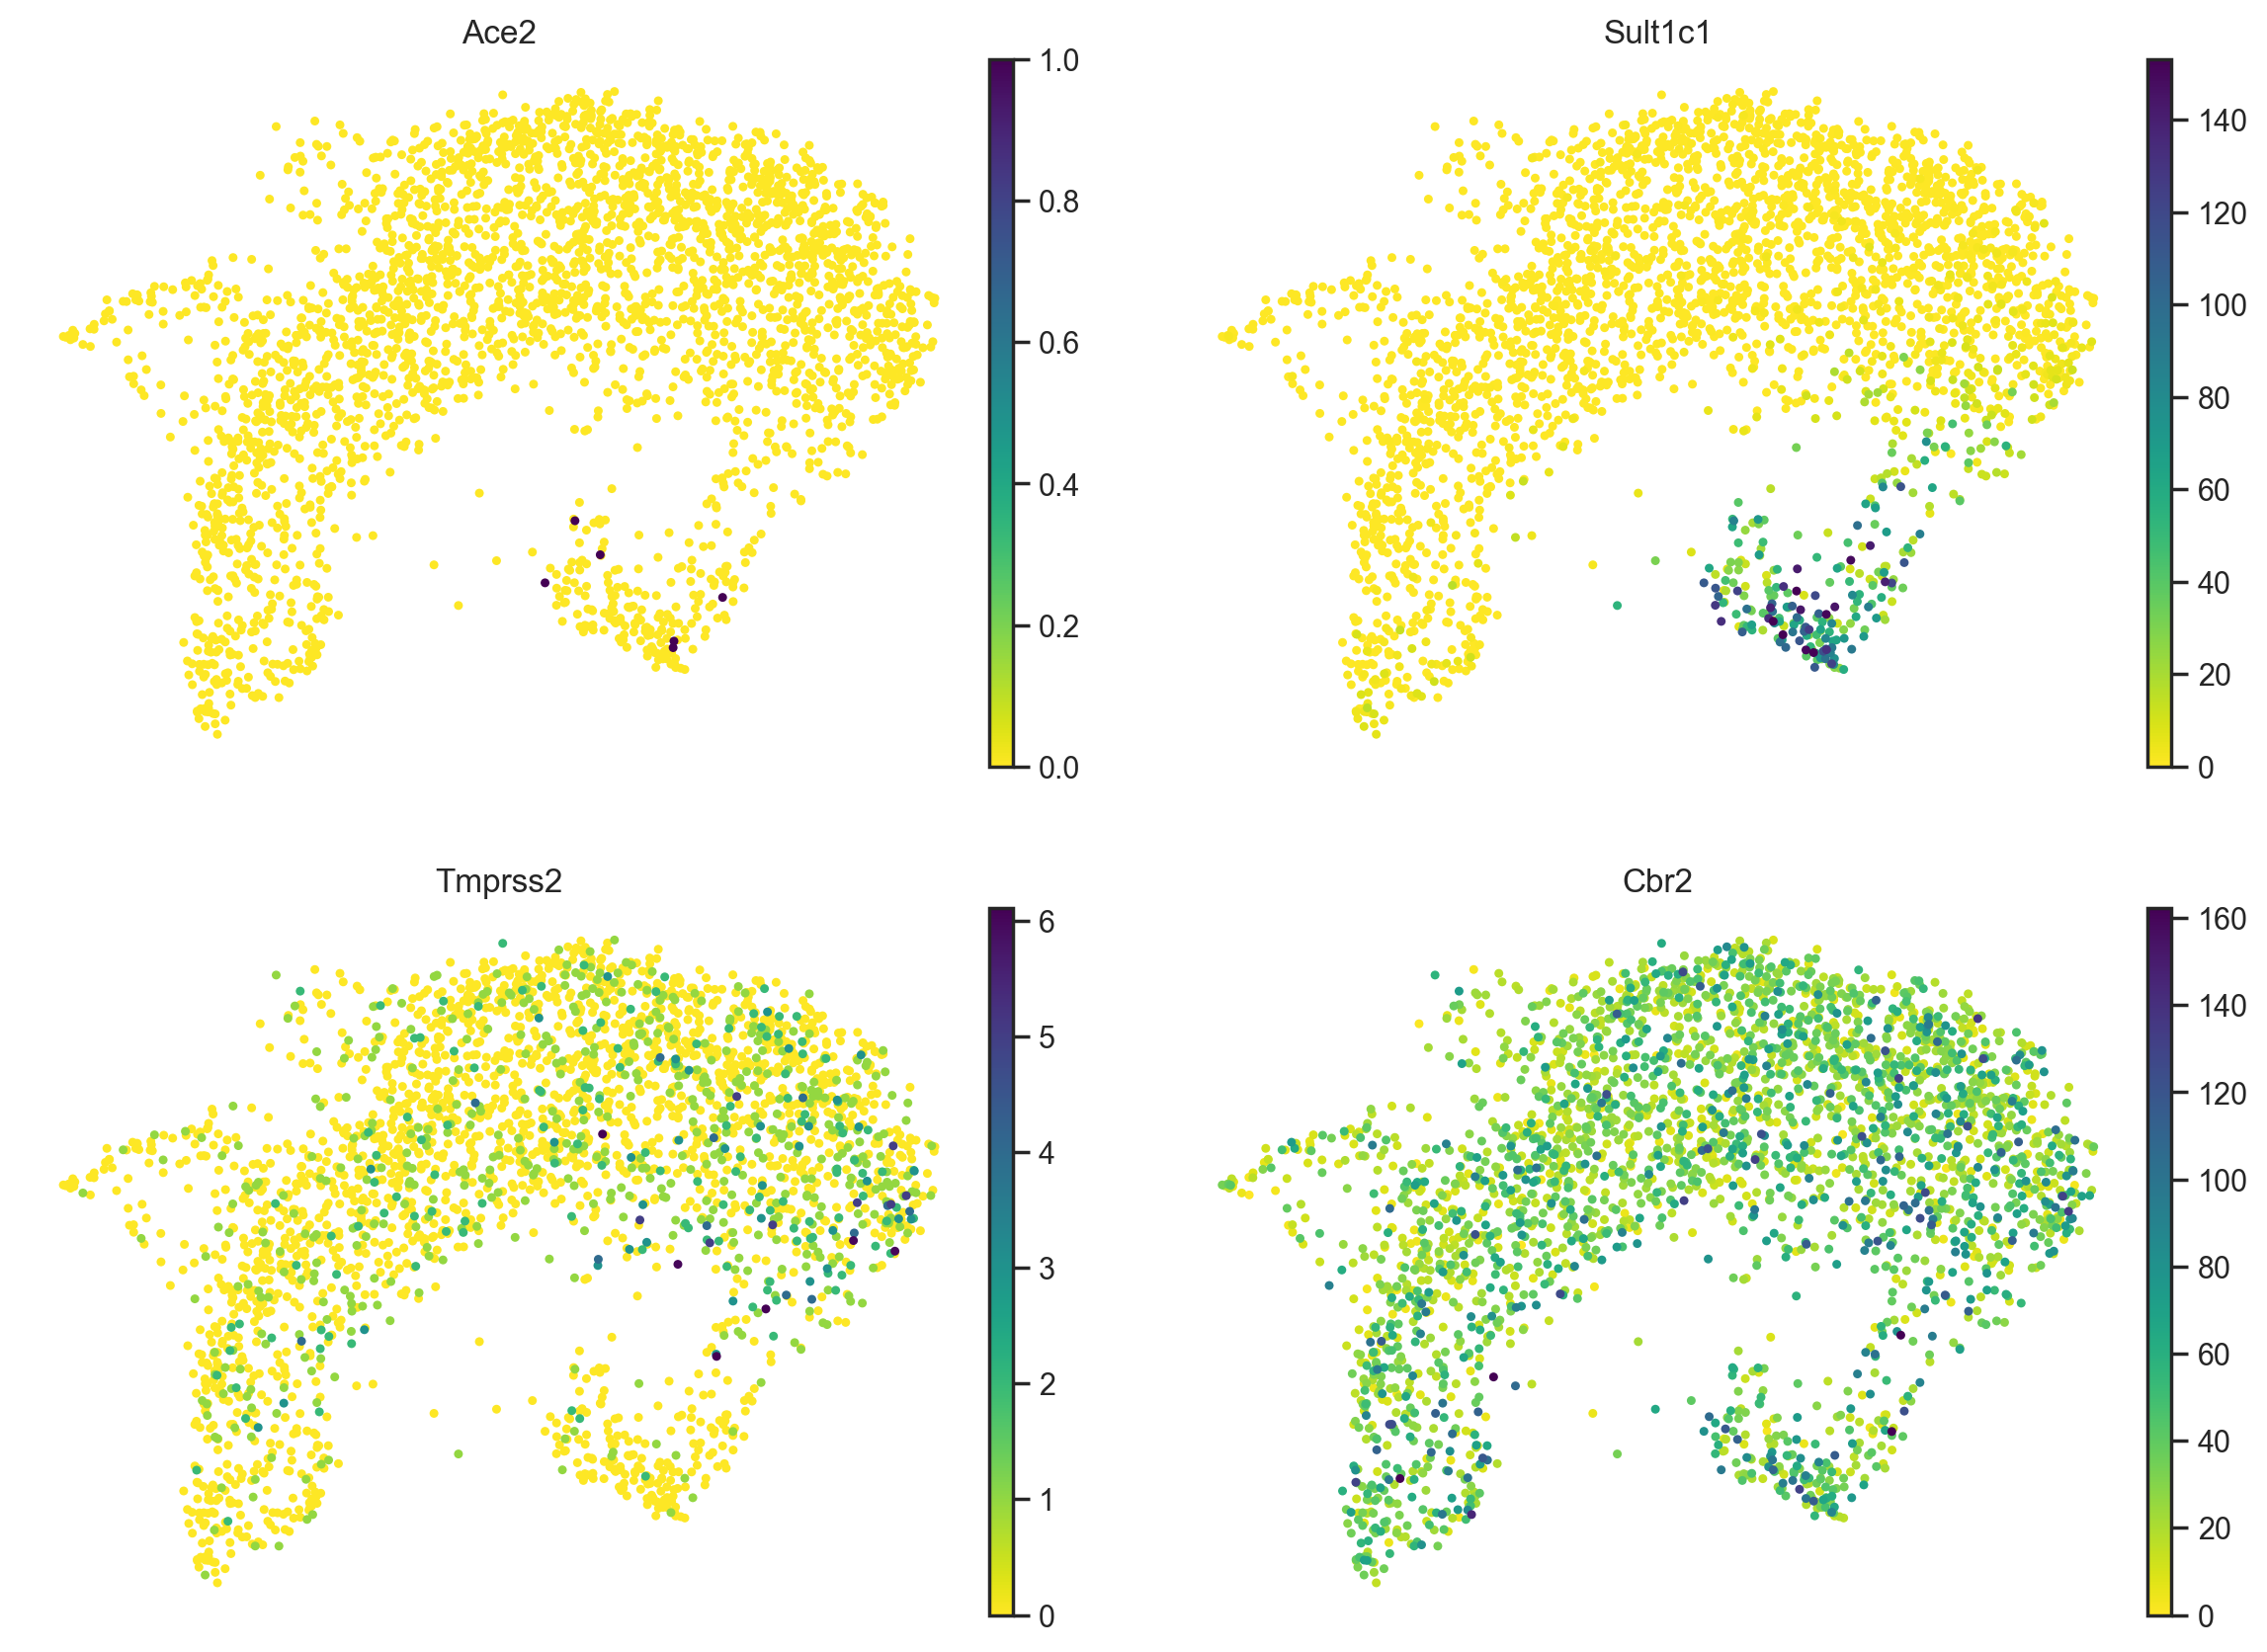

In [8]:
sc.pl.umap(
    adata_sus,
    color=["Ace2", "Sult1c1", "Tmprss2", "Cbr2"],
    ncols=2,
    frameon=False,
    cmap="viridis_r",
    vmax="p99.9",
    hspace=0.2, wspace=0.1
)

# plot example CoV genes

In [9]:
cov_genes = [
    "Ace2",
    "Tmprss2",
    "Ctsb",
    "Ctsl",
    "Bsg",
    "Hspa5",
    "Dpp4",
    "Furin",
    "Anpep",
    "Tmprss11d",
    "St6gal1",
    "St3gal4",
    "Ceacam1",
]
genes_of_interest = [
    "Krt5",
    "Krt14",
    "Cxcl14",
    "Ascl1",
    "Neurod1",
    "Gng8",
    "Gng13",
    "Cnga2",
    "Cbr2",
    "Cyp2g1",
    "Sult1c1",
    "Aqp5",
    "Sox9",
    "Trpm5",
    "Cftr",
    "Reg3g",
    "Adh7",
    "Muc5b",
    "Foxj1",
]

subset_order = [
    "Olf. HBC",
    "GBC",
    "INP",
    "iOSN",
    "mOSN",
    "SUS Ventral",
    "SUS Dorsal",
    "Bowman's gland",
    "MV Brush-like",
    "MV Ionocyte-like",
    "Resp. HBC",
    "Resp. ciliated",
    "Resp. secretory",
]

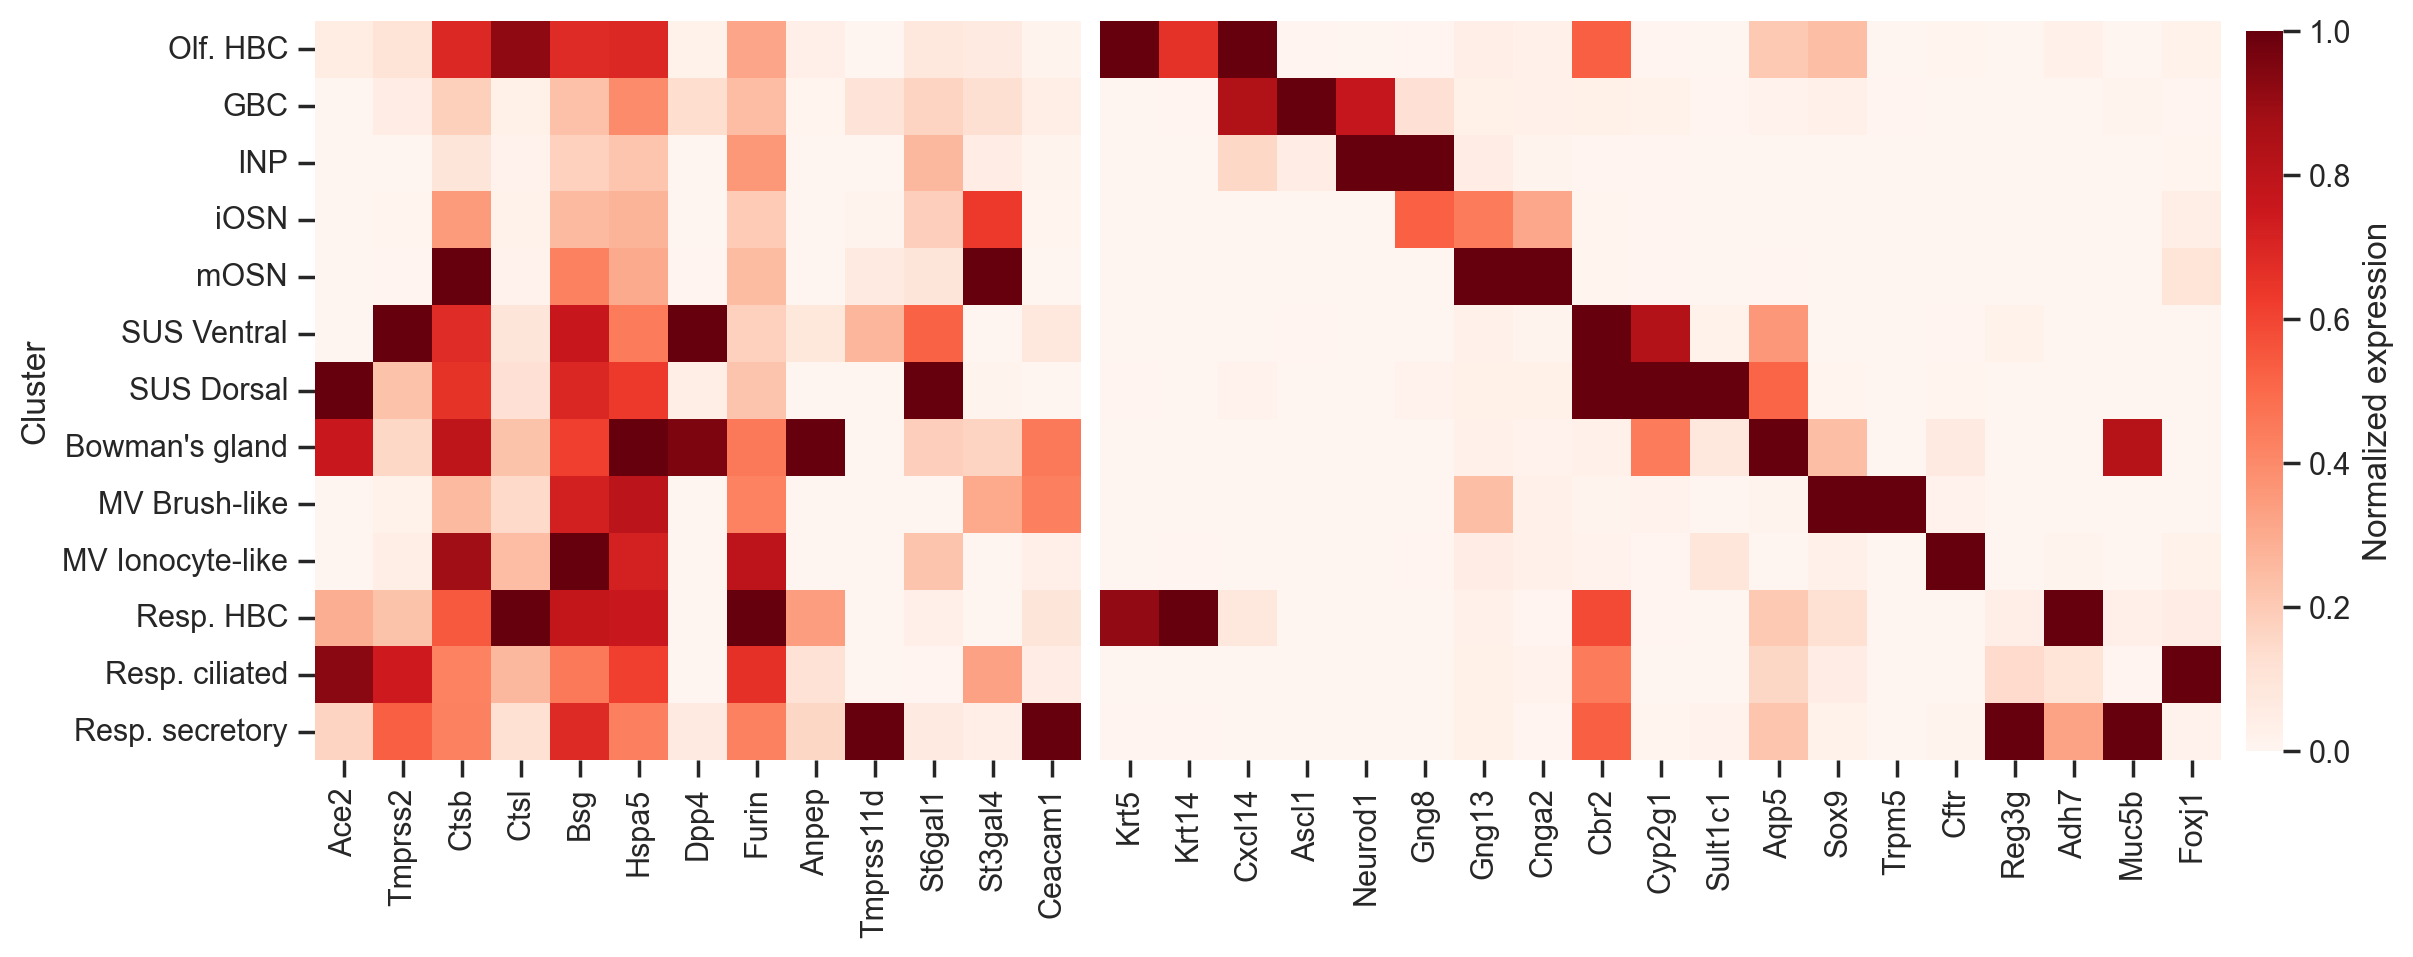

In [10]:
df_norm = viz.plot_heatmap(
    adata, genes_of_interest, cov_genes, subset_order, clust="leiden_name"
)

# plot pct of ACE2+ cells

In [11]:
# df_to_plot = df_ratio[["Ace2", "Tmprss2"]].loc[subset_order]
xlabs = [
    "HBC",
    "GBC",
    "INP",
    "iOSN",
    "mOSN",
    "SUS Ventral",
    "SUS Dorsal",
    "Bowman's gland",
    "MV Brush-like",
    "MV Ionocyte-like",
    "HBC",
    "Ciliated",
    "Secretory",
]
xl = [xlabs[:10], xlabs[10:]]

,Ace2,Tmprss2
leiden_name,,
Atypical OSN,0.000000,8.888889
Bowman's gland,3.829787,7.234043
GBC,0.000000,1.968504
INP,0.000000,0.114286
Immune,0.343643,0.000000
MV Brush-like,0.000000,0.757576
MV Ionocyte-like,0.000000,0.740741
Olf. HBC,0.180832,2.350814
Resp. HBC,0.925926,6.481481


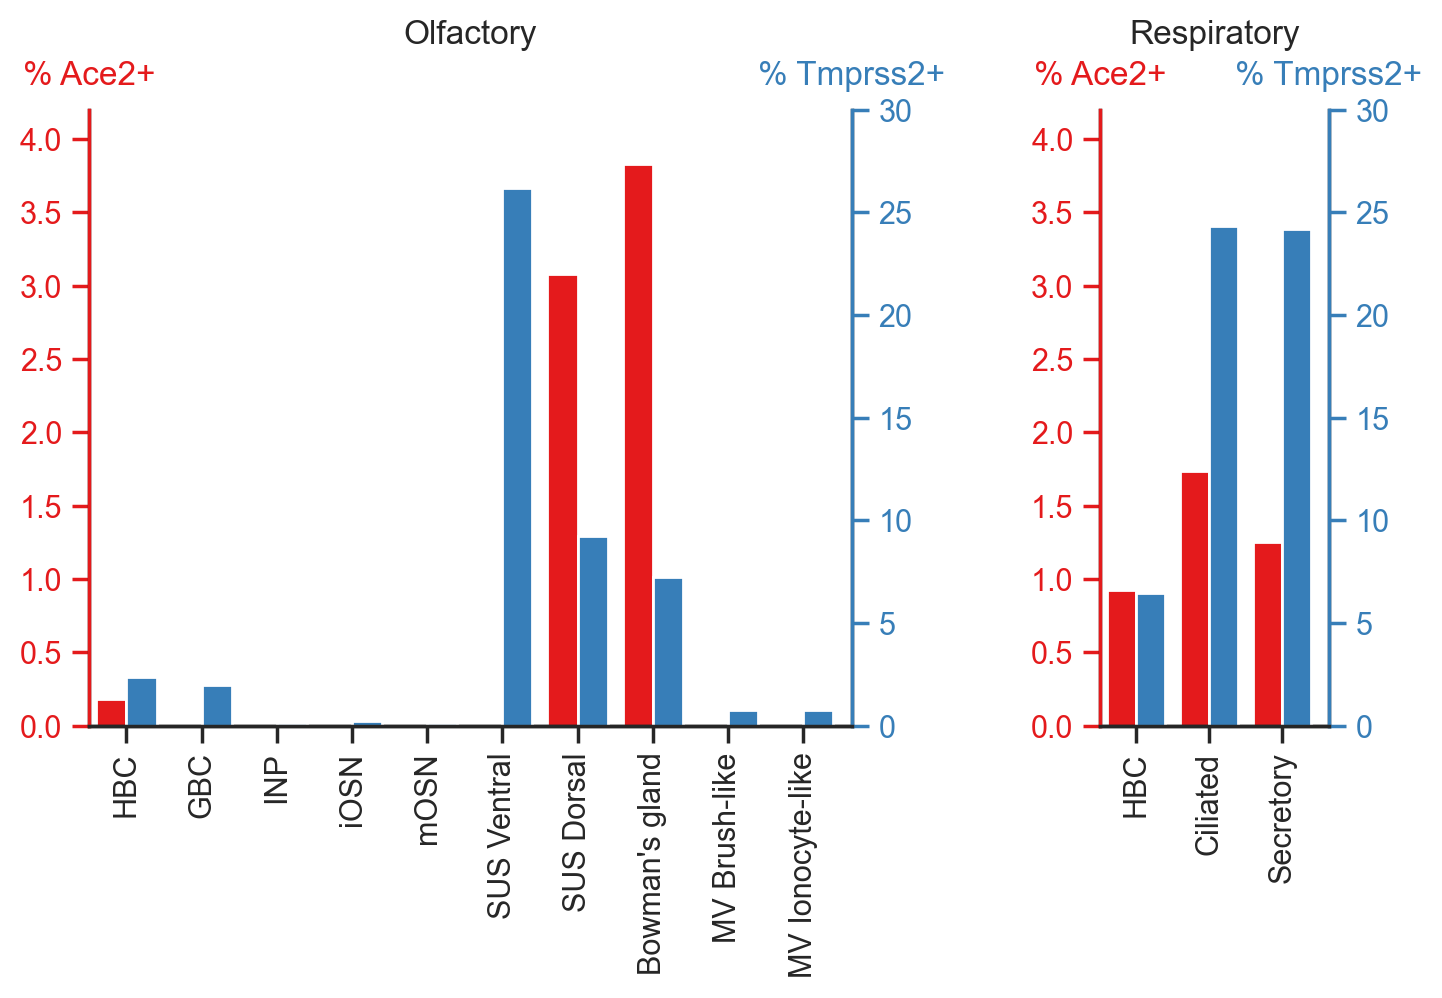

In [12]:
df_pct = viz.make_bar_plot(
    adata,
    (subset_order[:10], subset_order[10:]),
    xl,
    mouse=True,
    clust="leiden_name",
    ylims=(4.2, 30),
)
df_pct